# Setup

💡 = some conclusion is drawn from data<br/>
⚡ = some decision is made 

TO DO:<br/>
1. Characters: @, # ... (in progress...)
2. Spell Checks
3. word count per review/title histogram (eda)
4. topic modeling (eda)
5. NER(eda)
6. remove last sentence if it is not finished?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from copy import deepcopy
import re
import regex

from google.colab import data_table

In [ ]:
df = pd.read_csv('train.csv')
df.head(5)

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,14192,876,38,NaN,So this top is adorable light and airy and i l...,4,1,3,General Petite,Tops,Knits
1,3315,1084,22,Not for short or petite women,I bought this online with the intention of it ...,2,0,15,General Petite,Dresses,Dresses
2,15768,945,30,Amazing!,"Love this sweater! not too long or bulky,true ...",5,1,6,General,Tops,Sweaters
3,19020,976,52,Great for smaller women,"This is a well-made kimono style jacket, in a ...",4,1,0,General Petite,Jackets,Jackets
4,8469,863,51,Great summer tee,I tried this on in the store because i have ha...,5,1,3,General,Tops,Knits


In [ ]:
len(df)

2349

# Check empty values

In [ ]:
df.dtypes

Review ID                   int64
Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [ ]:
print(len(df[df['Title'] == None]))
print(len(df[df['Review Text'] == None]))

0
0


String columns should be converted to str type because object type can represent multiple types

In [ ]:
df['Review Text'] = df['Review Text'].values.astype(str)
df['Title'] = df['Title'].values.astype(str)

In [ ]:
print(len(df[df['Title'] == '']))
print(len(df[df['Review Text'] == '']))

0
0


In [ ]:
df['Title'].value_counts()

nan                        390
Beautiful                   15
Love it!                    13
Love                        11
Beautiful!                  10
                          ... 
Wear this tank anywhere      1
Flattering tee               1
Nice fit but runs small      1
Exquisite                    1
Pj's for the win             1
Name: Title, Length: 1699, dtype: int64

In [ ]:
df[df['Title'] == 'nan'].head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,14192,876,38,nan,So this top is adorable light and airy and i l...,4,1,3,General Petite,Tops,Knits
22,19811,868,29,nan,The design of this shirt is stunning. i can't ...,5,1,0,General,Tops,Knits
23,22004,860,27,nan,Lovely top that will be a great year-round sta...,5,1,14,General,Tops,Knits
26,5921,815,35,nan,nan,5,1,0,General,Tops,Blouses
27,3607,881,47,nan,This ia a great casual top...the design flaws ...,5,1,0,General,Tops,Knits


In [ ]:
df['Review Text'].value_counts()

nan                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                87
So this top is adorable light and airy and i like the loose fit, i think it will nice and cool for summer. the red is very flattering color, i have fairer skin and feel like it gave nice color without being overbearing. love this top. my only complaint is that i feel like the the arm hole is a bit snug. not enough to not keep, just wish there was a little more room.                                                                                                                                  

'nan' is same as empty string

In [ ]:
df['Title'] = df['Title'].apply(lambda x: '' if x == 'nan' else x)

In [ ]:
df['Title'].value_counts()

                           390
Beautiful                   15
Love it!                    13
Love                        11
Beautiful!                  10
                          ... 
Wear this tank anywhere      1
Flattering tee               1
Nice fit but runs small      1
Exquisite                    1
Pj's for the win             1
Name: Title, Length: 1699, dtype: int64

In [ ]:
len(df[(df['Review Text'] == 'nan') & (df['Title'] != '')])

1

💡 When review is empty, title is also empty 

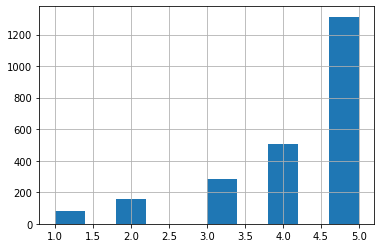

In [ ]:
df['Rating'].hist()

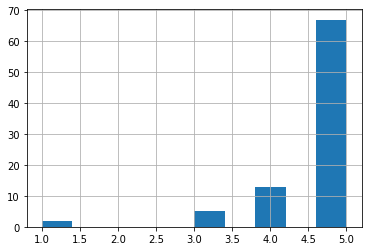

In [ ]:
df[df['Review Text'] == 'nan']['Rating'].hist()

💡 No correlation between empty reviews and rating

⚡ Remove empty reviews

In [ ]:
len(df)

2349

In [ ]:
df = df[df['Review Text'] != 'nan']

In [ ]:
len(df)

2262

# Check duplicate reviews

In [ ]:
review_text_counts_df = df['Review Text'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [ ]:
len(review_text_counts_df[review_text_counts_df['counts'] > 1])

0

In [ ]:
for review in review_text_counts_df[review_text_counts_df['counts'] > 1]['unique_values']:
  print(review)
  print('---------------------------------------')

In [ ]:
df[df['Review Text'].isin(review_text_counts_df[review_text_counts_df['counts'] > 1]['unique_values'])]

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name


⚡ No need to keep duplicate reviews

In [ ]:
len(df)

2262

In [ ]:
df.drop_duplicates(subset='Review Text', inplace=True)

In [ ]:
len(df)

2262

# Fix whitespaces

In [ ]:
df['Review Text'].str.contains('\n').sum()

194

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x.split()))

In [ ]:
df['Review Text'].str.contains('\n').sum()

0

# Check shortest/longest reviews and titles

In [ ]:
df['Title Length'] = df['Title'].apply(lambda x: len(x.split()))
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))

In [ ]:
df.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
0,14192,876,38,,So this top is adorable light and airy and i l...,4,1,3,General Petite,Tops,Knits,0,75
1,3315,1084,22,Not for short or petite women,I bought this online with the intention of it ...,2,0,15,General Petite,Dresses,Dresses,6,94
2,15768,945,30,Amazing!,"Love this sweater! not too long or bulky,true ...",5,1,6,General,Tops,Sweaters,1,17
3,19020,976,52,Great for smaller women,"This is a well-made kimono style jacket, in a ...",4,1,0,General Petite,Jackets,Jackets,4,60
4,8469,863,51,Great summer tee,I tried this on in the store because i have ha...,5,1,3,General,Tops,Knits,3,108


In [ ]:
df.sort_values('Title Length', ascending=False).head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
678,13637,1078,50,I love this dress so much i almost said a bad ...,"Omg, i am 5'8 size 14, big hips and i simply l...",5,1,3,General,Dresses,Dresses,12,58
1915,12294,569,46,"It's like a work of art, but sadly, not flatte...","It's like a work of art, but sadly, not flatte...",2,0,1,General,Trend,Trend,10,55
1231,21881,1052,25,"Yes to love, yes to life, yes to these pants",These are excellent. as previous reviewers not...,5,1,0,General,Bottoms,Pants,10,87
156,17654,918,49,"Long on sleeves, short in the torso. and - sna...","Well, it's the snails that really make this ca...",4,1,0,General,Tops,Fine gauge,10,99
585,15586,862,34,Feels lovely to the skin; 1 major flaw for me,I'm a sucker for anything in rich velvet tones...,4,1,12,General,Tops,Knits,10,96


In [ ]:
df[df['Title Length'] > 0].sort_values('Title Length', ascending=True).head(10)

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
407,16097,936,42,Gorgeous,I completely agree with the other reviewer. th...,5,1,4,General Petite,Tops,Sweaters,1,87
568,9344,895,59,Shrunk,Love it but it shrank and that makes me so mad.,4,1,3,General,Tops,Fine gauge,1,11
1858,10964,1083,36,Gor-geous,"This dress is absolutely fantastic. beautiful,...",5,1,0,General,Dresses,Dresses,1,19
1855,11809,865,24,Unique+flattering+easy,This top is great for those days when you have...,5,1,1,General,Tops,Knits,1,23
982,21016,1078,41,Gorgeous!!,Easy breezy summer dress!!! love the detailing...,5,1,6,General,Dresses,Dresses,1,10
985,22633,886,47,Cute!,Got this today and highly recommend it! it fit...,5,1,0,General Petite,Tops,Knits,1,25
563,18187,1087,65,Disappointing,I really wanted to love this dress. i thought ...,3,0,6,General,Dresses,Dresses,1,102
1453,5251,871,53,Love!,I got the green one. as the other reviewers co...,5,1,0,General,Tops,Knits,1,33
561,13473,1024,55,Love!,So glad to see high waisted jeans again! very ...,5,1,0,General,Bottoms,Jeans,1,22
465,22192,824,63,Beautiful,"Love, love this top. fabric is nice and soft, ...",5,1,0,General,Tops,Blouses,1,27


💡 No insights from Title Length

In [ ]:
data_table.enable_dataframe_formatter()
df.sort_values('Review Length', ascending=False).head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
930,17909,861,43,Fit off,I got a medium as i usually wear that in every...,3,1,9,General,Tops,Knits,2,114
2108,15096,881,21,Pretty but the doesn't fit right.,"Alright, so i really love this shirt. but i am...",4,1,4,General,Tops,Knits,6,113
1644,6368,1059,52,Dress them up or down,Let me talk about the fit. i am a size 6 petit...,5,1,5,General,Bottoms,Pants,5,113
2177,18708,872,27,Perfect light weight sweater,I ordered the cream colored duster after purch...,5,1,0,General,Tops,Knits,4,113
517,12466,927,36,Love this vest,I have been looking for a vest this winter and...,5,1,2,General Petite,Tops,Sweaters,3,109


💡 Seems like longest reviews are truncated :/ also in original file :(

In [ ]:
data_table.disable_dataframe_formatter()
df.sort_values('Review Length', ascending=True).head(10)

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Title Length,Review Length
1216,4274,857,55,,Love this top!,5,1,1,General,Tops,Knits,0,3
2311,22325,1077,46,,"Love this dress, beautiful!",5,1,0,General Petite,Dresses,Dresses,0,4
474,4888,826,41,Absolutely beautiful,Got the green one,5,1,0,General Petite,Tops,Blouses,2,4
51,8740,952,43,Lovely sweater!,This is a beautiful sweater.,5,1,0,General,Tops,Sweaters,2,5
1318,7966,862,63,Basic go to,Love the feel and comfort,3,1,0,General Petite,Tops,Knits,3,5
932,21640,1109,32,Soft and easy,"Fits well, soft and comfortable",5,1,0,General Petite,Dresses,Dresses,3,5
687,8493,861,63,Easy,"Easy, breezy comfortable light weight tee",5,1,0,General,Tops,Knits,1,6
909,23240,859,53,Super cute top,"Very comfortable, flattering, washes nicely- l...",4,1,1,General,Tops,Knits,3,7
574,976,154,48,Cozy comfy beautiful top,I was initially attracted to the colors,5,1,1,Initmates,Intimate,Sleep,4,7
110,19092,879,32,,"Love this top! so soft, fits perfect.",5,1,1,General,Tops,Knits,0,7


💡 Review is 'Very pretty, romantic' and rating is 3 :/ 

# Fix potential HTML

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: BeautifulSoup(x).get_text(separator=' ')) 
df['Title'] = df['Title'].apply(lambda x: BeautifulSoup(x).get_text(separator=' ')) 

# Check unwanted characters

In [ ]:
characters = ['#', '&', '@', '_']
for c in characters:
  print(c, df['Review Text'].str.contains(c).sum())

# 27
& 50
@ 1
_ 4


In [ ]:
for x in df[df['Review Text'].str.contains('@')]['Review Text'][:10]:
  print(x)
  print('--------------------------------------')

I ordered this a little big because the smallest size that they had was a medium. i probably could have gone with a small, but given that i am a 34d on top (and @ a size 2 on the bottom & @ 120lbs), the medium fits me just fine. it is super soft, and you can wear it with just about anything. keep in mind that your midriff may show a bit depending on how high your bottoms are. however, i paired it with a white pair of skinny jeans with a cute belt (so a teeny bit of my midriff was showing at time
--------------------------------------


💡 somewhere @ means 'at', somewhere can be removed

In [ ]:
for x in df[df['Review Text'].str.contains('#')]['Review Text'][:10]:
  print(x)
  print('--------------------------------------')

Love the look and quality of this jacket. i&#39;d say it fits true to size but it is way too short for me (i&#39;m just under 6&#39; tall). wish these came in tall sizes!
--------------------------------------
I bought this sweater in the lovely lilac and black. the sweater is a typical cotton weave in the front with more of a t-shirt material on the back. the drape is lovely after a quick iron. swingy with a flirty neckline. my middle us still recovering from baby #2 and this does a nice job of covering the bump. interestingly, i think they went overboard on the fabric and pleats and i could easily have down sized from a large (wear size 12) to a medium.
--------------------------------------
I had my eye on this for a while, and my store finally got it in (in tmie for the 40% off sweaters). too bad hte petite size was already sold out by then, however good thing isthe xs stil lfit me in a nice way. i wil lnever know about petite, decided to jsut purchase as is (they don't have xxs ei

💡 1. most commonly # goes after number, in most cases it is related to weight (in pounds(lbs)), replace with lbs ⚡</br>
2. `&#39;` represents single quote, which should be replaced ⚡

In [ ]:
df['Review Text']  = df['Review Text'].apply(lambda x: regex.sub(r'(?<=[0-9]+)#', ' lbs', x))
df['Review Text'] = df['Review Text'].apply(lambda x: x.replace("amp;", ""))
df['Review Text'] = df['Review Text'].apply(lambda x: x.replace("&#39;", "'")) 

# Check links

In [ ]:
print('http in title >>', df['Review Text'].str.contains('http').sum())
print('http in review >>', df['Review Text'].str.contains('http').sum())

http in title >> 0
http in review >> 0


# Check non-ascii characters

In [ ]:
df['Not ascii characters title'] = df['Title'].apply(lambda x: not x.isascii())
df['Not ascii characters review'] = df['Review Text'].apply(lambda x: not x.isascii())

print('Not ascii titles: ', str(round(len(df[df['Not ascii characters title']])/len(df)*100, 2)) + ' %')
a = len(df[df['Not ascii characters review']])
b = len(df)
c = round(len(df[df['Not ascii characters review']])/len(df)*100, 2)
print(f'Not ascii reviews: {a} / {b} = {c} %')

Not ascii titles:  0.0 %
Not ascii reviews: 3 / 2262 = 0.13 %


In [ ]:
for x in df[df['Not ascii characters review']]['Review Text']:
    print(x)
    print('------------------------')

Love this top! it has a beautiful appliquã© that is reminiscent of many past retailer favorites. it's comfy, yet cute and fashionable.
------------------------
I loved this dress so much i bought in the cream/pink as well as the blue/teal. it is so light and easy to throw on. the slits are higher on me (i am 5'2) but not in a risquã© way. it's very flattering and gives it a little sassiness. i wish they had even more colors to choose from. that is how obsessed i am with it!
------------------------
The rest of the reviewers are right about the color being in accurately pictured. i ordered the dark orange color and i recieved more of a dark cedar brown colored jacket. the print is great, i love it! it's so different than any other jackets ive seen. while the jacket is ã¼ber cute, it is a bit bulky (though the waist tie helps with that) and its not heavy winter appropriate ( it's not waterproof or heavily insulated). for your average winter day though, it will be a fun option! the remova

💡 words with non-ascii characters: <br/>
<br/>
â â   x1 <br/>
dã©colletã©   x1 <br/>
appliquã©   x10 <br/> 
derriã©re   x1 <br/>
ombrã©   x4<br/>
derriã¨re   x4<br/>
fiancã©   x1<br/>
dã©colletage   x1<br/>
risquã©   x1<br/>
aprã¨s-ski   x1<br/>
<br/>
According to [this](https://www.i18nqa.com/debug/utf8-debug.html) source:<br/>
ã© => é<br/>
ã¨ => é<br/>
<br/>
⚡ <br/>
â â => remove <br/>
ã© and ã¨ => replace with simple e <br/>

In [ ]:
df['Review Text'] = df['Review Text'].str.replace('â â', '')
df['Review Text'] = df['Review Text'].str.replace('ã©', 'e')
df['Review Text'] = df['Review Text'].str.replace('ã¨', 'e')

In [ ]:
df['Not ascii characters review'] = df['Review Text'].apply(lambda x: not x.isascii())
print(f'Not ascii reviews: ', len(df[df['Not ascii characters review']]))

Not ascii reviews:  1


# Check emojis

In [ ]:
!pip install emot

In [ ]:
import emot 
emot_obj = emot.core.emot()
print('Emoji') 
print(emot_obj.emoji('🙂'))
print('\nNo emoji') 
print(emot_obj.emoji(' text '))
print('\nEmoticon') 
print(emot_obj.emoticons(' :) '))
print('\nNo emoticon') 
print(emot_obj.emoticons(' text '))

Emoji
{'value': ['🙂'], 'location': [[0, 1]], 'mean': [':slightly_smiling_face:'], 'flag': True}

No emoji
{'value': [], 'location': [], 'mean': [], 'flag': False}

Emoticon
{'value': [':)'], 'location': [[1, 3]], 'mean': ['Happy face or smiley'], 'flag': True}

No emoticon
{'value': [], 'location': [], 'mean': [], 'flag': False}


In [ ]:
df['Emoji in Title'] = df['Title'].apply(lambda x: emot_obj.emoji(x)['flag'])
df['Emoji in Review Text'] = df['Review Text'].apply(lambda x: emot_obj.emoji(x)['flag'])
df['Emoticons in Title'] = df['Title'].apply(lambda x: emot_obj.emoticons(x)['flag'])
df['Emoticons in Review Text'] = df['Review Text'].apply(lambda x: emot_obj.emoticons(x)['flag'])

print('Number of titles with emojis: ', len(df[df['Emoji in Title']]))
print('Number of reviews with emojis: ', len(df[df['Emoji in Review Text']]))
print('Number of titles with emoticons: ', len(df[df['Emoticons in Title']]))
print('Number of reviews with emoticons: ', len(df[df['Emoticons in Review Text']]))

Number of titles with emojis:  0
Number of reviews with emojis:  0
Number of titles with emoticons:  4
Number of reviews with emoticons:  48


In [ ]:
def get_emoticons_dict(column):
  emoticons_title_dict = {}
  for x in df[df[f'Emoticons in {column}']][column]:
    result = emot_obj.emoticons(x)
    for emoticon in result['value']:
      if emoticon not in emoticons_title_dict:
        emoticons_title_dict[emoticon] = []
      emoticons_title_dict[emoticon].append(x)
  return emoticons_title_dict

def emoticons_to_count(emoticons_dict):
  items = emoticons_dict.items()
  items = [(item[0], len(item[1])) for item in items]
  items = sorted(items, key=lambda x: x[1], reverse=True)
  return items

In [ ]:
emoticons_title_dict = get_emoticons_dict('Title')
emoticons_to_count(emoticons_title_dict)

[(':)', 2), (':(', 2)]

In [ ]:
top = 2
for emoticon in emoticons_title_dict:
  print(emoticon)
  for sentence in emoticons_title_dict[emoticon][:top]: 
    print(sentence)
  print('-------------------------------')

:)
Love this thing :)
Lovely :)
-------------------------------
:(
Tassels :(
Not for big girls :(
-------------------------------


💡 Not all emojis detected with this library are valid!

In [ ]:
emoticons_review_dict = get_emoticons_dict('Review Text')
emoticons_to_count(emoticons_review_dict)

[(':(', 17), (':)', 16), (':-)', 6), (';)', 5), ('d:', 3), (':/', 1)]

In [ ]:
for emoticon in emoticons_review_dict:
  if len(emoticons_review_dict[emoticon]) < 5:
    print(emoticon)
    for sentence in emoticons_review_dict[emoticon]: 
      print(sentence)
    print('-------------------------------')

d:
I'm: 34a, 125 lbs, 5'8" purchased: small i was going back and forth between xs and s. i decided on small because it fit better in my arms, didn't feel as tight. the xs fit well in the torso area and didn't have as much fabric as the small. the small also had a longer shirt tail. if you don't have as much mass in the arms, get the xs. if you have some muscle or extra mass in the arms, it's better to go with the small.
Swimsuit shopping can be the worst. it's difficult to find bathing suits that fit well and are flattering. this swim top is a winner. the straps are comfortable, and the scoop in the front was not too low for a 36d cup. the best part is the higher back! a lot of swimwear dips in the back, but this does not (read: eliminates the dreaded back fat). my only concern was that it isn't super supportive for larger busts, but i'm keeping it because i love the straps and how it flatters overall. this wou
This shirt is made of fabric so soft you can practically feel it with your 

In [ ]:
emoticon = 'd:'
top = 5
for sentence in emoticons_review_dict[emoticon][:top]:
  print(sentence)
  print('-------------------------------')

I'm: 34a, 125 lbs, 5'8" purchased: small i was going back and forth between xs and s. i decided on small because it fit better in my arms, didn't feel as tight. the xs fit well in the torso area and didn't have as much fabric as the small. the small also had a longer shirt tail. if you don't have as much mass in the arms, get the xs. if you have some muscle or extra mass in the arms, it's better to go with the small.
-------------------------------
Swimsuit shopping can be the worst. it's difficult to find bathing suits that fit well and are flattering. this swim top is a winner. the straps are comfortable, and the scoop in the front was not too low for a 36d cup. the best part is the higher back! a lot of swimwear dips in the back, but this does not (read: eliminates the dreaded back fat). my only concern was that it isn't super supportive for larger busts, but i'm keeping it because i love the straps and how it flatters overall. this wou
-------------------------------
This shirt is 

In [ ]:
def fix_emoticons(row):
  if row['Emoticons in Title']:
    row['Title'] = row['Title'].replace('d:(', 'd :(')
    row['Title'] = row['Title'].replace('=))', '=)')
  if row['Emoticons in Review Text']:
    row['Review Text'] = row['Review Text'].replace('d:(', 'd :(')
    row['Review Text'] = row['Review Text'].replace('=))', '=)')
  return row

emoticons_to_ignore = ['=/', 'd:', '%)', '*)']

def remove_emoticons(row):
  if row['Emoticons in Title']:
    result = emot_obj.emoticons(row['Title'])
    for emoticon in result['value']:
      if emoticon not in emoticons_to_ignore:
        row['Title'] = row['Title'].replace(emoticon, ' ')
  if row['Emoticons in Review Text']:
    result = emot_obj.emoticons(row['Review Text'])
    for emoticon in result['value']:
      if emoticon not in emoticons_to_ignore:
        row['Review Text'] = row['Review Text'].replace(emoticon, ' ')
  return row

def replace_emoticons(row):
  if row['Emoticons in Title']:
    result = emot_obj.emoticons(row['Title'])
    for emoticon, meaning in zip(result['value'], result['mean']):
      if emoticon not in emoticons_to_ignore:
        row['Title'] = row['Title'].replace(emoticon, f' {meaning} ')
  if row['Emoticons in Review Text']:
    result = emot_obj.emoticons(row['Review Text'])
    for emoticon, meaning in zip(result['value'], result['mean']):
      if emoticon not in emoticons_to_ignore:
        row['Review Text'] = row['Review Text'].replace(emoticon, f' {meaning} ')
  return row

df = df.apply(lambda row: fix_emoticons(row), axis=1)

df_removed_emoticons = deepcopy(df)
df_replaced_emoticons = deepcopy(df)
df_removed_emoticons = df_removed_emoticons.apply(lambda row: remove_emoticons(row), axis=1)
df_replaced_emoticons = df_replaced_emoticons.apply(lambda row: replace_emoticons(row), axis=1)

In [ ]:
df[df['Emoticons in Title']]['Title'].head()

737       Love this thing :)
1106              Tassels :(
1137               Lovely :)
2190    Not for big girls :(
Name: Title, dtype: object

In [ ]:
df_replaced_emoticons[df_replaced_emoticons['Emoticons in Title']]['Title'].head()

737               Love this thing  Happy face or smiley 
1106              Tassels  Frown, sad, andry or pouting 
1137                       Lovely  Happy face or smiley 
2190    Not for big girls  Frown, sad, andry or pouting 
Name: Title, dtype: object

In [ ]:
df_removed_emoticons[df_removed_emoticons['Emoticons in Title']]['Title'].head()

737       Love this thing  
1106              Tassels  
1137               Lovely  
2190    Not for big girls  
Name: Title, dtype: object

# Save cleaned dataset

Fix whitespaces again

In [ ]:
df['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x.split()))
df_removed_emoticons['Review Text'] = df_removed_emoticons['Review Text'].apply(lambda x: ' '.join(x.split()))
df_replaced_emoticons['Review Text'] = df_replaced_emoticons['Review Text'].apply(lambda x: ' '.join(x.split()))
df['Title'] = df['Title'].apply(lambda x: ' '.join(x.split()))
df_removed_emoticons['Title'] = df_removed_emoticons['Title'].apply(lambda x: ' '.join(x.split()))
df_replaced_emoticons['Title'] = df_replaced_emoticons['Title'].apply(lambda x: ' '.join(x.split()))

Remove duplicates again

In [ ]:
print('df_removed_emoticons')
print(len(df_removed_emoticons))
df_removed_emoticons.drop_duplicates(subset='Review Text', inplace=True)
print(len(df_removed_emoticons))
print()
print('df_replaced_emoticons')
print(len(df_replaced_emoticons))
df_replaced_emoticons.drop_duplicates(subset='Review Text', inplace=True)
print(len(df_replaced_emoticons))
print()
print('df')
print(len(df))
df.drop_duplicates(subset='Review Text', inplace=True)
print(len(df))

df_removed_emoticons
2262
2262

df_replaced_emoticons
2262
2262

df
2262
2262


In [ ]:
df.to_csv('train_clean_with_emoticons.csv', index=False)
df_removed_emoticons.to_csv('train_clean_removed_emoticons.csv', index=False)
df_replaced_emoticons.to_csv('train_clean_replaced_emoticons.csv', index=False)